# 第3讲：大模型怎么玩：用LazyLLM带你理解调用逻辑与Prompt魔法

>上期，我们介绍了基础的RAG的基本概念，以及如何用LazyLLM实现一个基础的RAG。本期我们将深入介绍LazyLLM的特性，以Lazy的方式，逻辑更加清晰地构建出一个以数据流为核心范式的RAG应用。
>
>在此次教程中，您不仅可以学习到LazyLLM中的各种数据流的使用、还可以更加深入地学到如何使用在线和本地的大模型，并为它们设置上Prompt，同时还可以复用同一个本地大模型来构建多个不同角色的大模型，最后本教程将带领您一步步优化上期RAG，以LazyLLM中的数据流来重构基础RAG!
>
>让我们开始吧\~
>
欢迎来到 LazyLLM！

LazyLLM 是一款构建多Agent大模型应用的开发框架，协助开发者用极低的成本构建复杂的AI应用，并可以持续的迭代优化效果。基于LazyLLM的AI应用构建流程是：

**原型搭建 → 数据**​**分析**​**​ → 迭代优化**

用户可以先基于LazyLLM快速跑通应用的原型，再结合场景任务数据进行bad-case分析，然后对应用中的关键环节进行算法迭代和模型微调，进而逐步提升整个应用的效果。LazyLLM 的设计目标是让算法研究员和开发者能够从繁杂的工程实现中解脱出来，从而专注算法和数据。

LazyLLM为同一模块的不同技术选型提供了一致的使用体验 -- 统一调用、统一服务、统一部署。

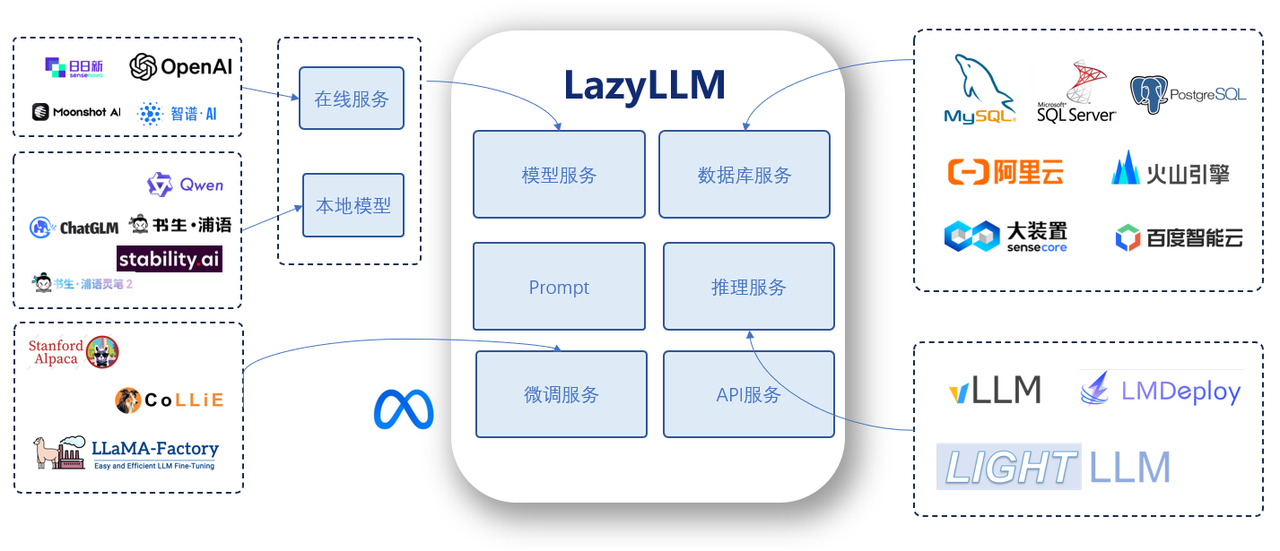

对于初级开发者，LazyLLM 彻底简化了AI应用的构建过程。用户不必了解不同模型 API 服务的构建细节，无需在微调模型时选择框架或切分模型，也不需要掌握任何Web开发知识，通过预置的组件和简单的拼接操作，初级开发者便能轻松构建出具备生产价值的工具。

对于资深的专家，LazyLLM 提供了极高的灵活性，为开发者提供了无限的可能性。其模块化设计支持高度的定制与扩展，使用户能够轻松集成自有算法、行业领先的生产工具以及最新的技术成果，从而快速构建适配多样化需求的强大应用。

本教程主要介绍 LazyLLM 的基本使用方法，读完本教程，您将学会 LazyLLM 最基本的用法和核心设计思路，可以自己搭建一个简单的聊天机器人，为其指定角色并进行聊天。

更多LazyLLM使用教程及API文档请参考：[LazyLLM官方文档](https://docs.lazyllm.ai/zh-cn/stable/) 或 B站一键三连：

[相关视频：video/1.居然有比LangChain还好用的多Agent应用开发框架？(Av113632839013182,P1).mp4](video/1.居然有比LangChain还好用的多Agent应用开发框架？(Av113632839013182,P1).mp4)

## 环境的准备 ✈

如果您的电脑上安装了Python，请通过下方命令安装基础的lazyllm及必要的依赖包。更多LazyLLM的安装细节，可见上期的教程的环境准备部分。

**从pip安装**


```bash
pip install lazyllm
```

**从源码安装**


```bash
git clone https://github.com/LazyAGI/LazyLLM.git
cd LazyLLM
pip3 install -r requirements.txt
export PYTHONPATH=$PWD:$PYTHONPATH
```



## 调用大模型 🤖

LazyLLM支持调用线上模型和本地模型，为二者提供了一致的使用体验，做到模型即黑盒，您只需关注输入输出及相关参数的具体取值，而无需研究不同模型调用上的差异。

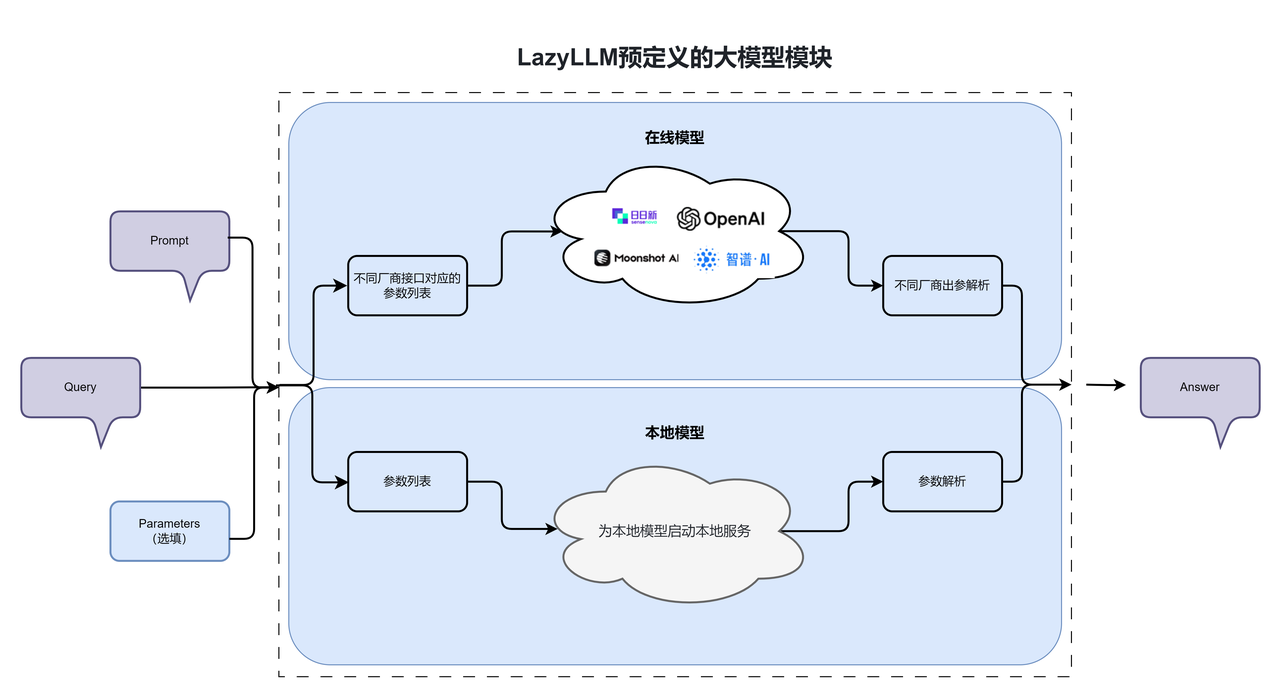
 ### 1. 调用在线大模型 🌏

LazyLLM 通过 OnlineChatModule 统一调用线上大模型接口，不管您使用的OpenAPI接口还是SenseNova接口，或者是其他平台提供的接口，LazyLLM均为您进行了规范的参数封装，您只需要根据自己的需求将模型名称等参数传给对应的模块即可。

❗❗❗ 注意，您需要在开始调试前，将您的API key设置为环境变量，如您没有指定任何环境变量程序将报错。您可以参考上期教程进行设置。例如当您需要访问SenseNova时，您需要设定环境变量:



```bash
export LAZYLLM_SENSENOVA_API_KEY="..."
export LAZYLLM_SENSENOVA_SECRET_KEY="..."
```



如果您只配置了一个平台的API key，则无需指定平台名称，直接调用 OnlineChatModule 即可。如果配置了多个平台的API key，在没指定平台名称的情况下，会按照openai>sensenova>glm>kimi>qwen的顺序进行平台查找。当您需要指定具体平台时，需要为OnlineChatModule传入平台名称；如果需要指定具体模型，则需要传入对应模型名称。



In [ ]:
llm = lazyllm.OnlineChatModule(source="sensenova")

# 指定具体模型
sensechat = lazyllm.OnlineChatModule("sensenova", model="SenseChat-5")



下面我们使用LazyLLM调用一个线上模型（已在环境变量中设置了SenseNova相关的KEY）



In [ ]:
import lazyllm

online_model = lazyllm.OnlineChatModule()
print(online_model("你好，你是谁?"))



[相关视频：video/a1chat_online1.mp4](video/a1chat_online1.mp4)

如果您没有开通相应的模型服务，可以通过输入 model 参数指定模型，例如



In [ ]:
import lazyllm

online_model = lazyllm.OnlineChatModule(source="sensenova", model="DeepSeek-V3")
print(online_model("你好，你是DeepSeek吗？"))



[相关视频：video/a1chat_online2.mp4](video/a1chat_online2.mp4)

 ### 2. 调用本地大模型 💻

LazyLLM 中的 TrainableModule 为所有本地模型(包括llm、Embedding、多模态模型等)提供服务，可用于本地模型的训练、微调和推理。调用本地大模型依赖于其推理服务，我们回顾一下使用本地模型进行推理的步骤：

（1）通过推理框架启动本地模型服务；

（2）在python脚本中进行接口调用。

LazyLLM提供了一种非常 lazy 的实现方式，只需将模型所在的路径传入 LazyLLM 的`TrainableModule `然后通过`start()`函数启动服务即可。这里需要您传入模型文件的绝对路径，或者配置环境变量`LAZYLLM_MODEL_PATH`指定模型所在的目录，然后将模型名称传入`TrainableModule`。如果您本地没有该模型，LazyLLM会为您下载对应模型并存入模型缓存目录，默认情况下会下载到您的家目录下的 ".lazyllm/model" 目录；您可以通过配置 `“LAZYLLM_MODEL_CACHE_DIR” `环境变量指定模型缓存目录。

值得一提的是 LazyLLM 支持多种推理框架，如：LightLLM 和 vLLM等，在不指定明确框架下LazyLLM会根据模型大小和测试数据等信息，自动为用户选择合适的推理框架。如果要明确指定一个推理框架，我们可以这么来设定：



[代码GitHub链接](https://github.com/LazyAGI/Tutorial/blob/7abc91dbb82a007a78731845dd8c360ac0cc1e75/rag/codes/chapter3/chat_local.py#L1)

In [ ]:
import lazyllm
from lazyllm import deploy

llm = lazyllm.TrainableModule('internlm2-chat-7b').\
        deploy_method((deploy.Vllm, {
            'port': 8081,
            'host': '0.0.0.0',
        })).start()
res = llm('hi')
print("大模型的输出是：", res)



上面代码中，使用`deploy_method`来配置推理框架：

* `deploy.Vllm` 指定使用vLLM作为推理引擎；
* `host` 和` port` 参数分别指定了服务部署时候的IP和地址；

[相关视频：video/a1chat_local.mp4](video/a1chat_local.mp4)

 ### 3. Prompt配置使用💭

Prompt 是指在自然语言处理（NLP）或人工智能（AI）系统中输入给模型的文本或指令，是与模型交互的主要方式。Prompt 不仅是用户输入的文本，它在很多情况下是模型理解任务的关键，通过设计合适的 Prompt，我们可以引导模型以特定的方式生成所需的响应。

Prompt 的主要作用是给模型提供任务的上下文信息，比如在对话中，模型会根据预定义的系统说明和用户输入进行回复。不同的提示会引导模型生成不同的答案。因此，Prompt 的设计直接影响到生成内容的质量、准确性和相关性。利用大模型进行问答系统时，我们可以通过 Prompt 指定大模型扮演的角色以及回答问题的风格等。

#### 基础的Prompt

使用 LazyLLM 提供的 Prompt 模板，您只需要在初始化大模型时通过如下语法进行定义，在调用时直接传入用户输入即可。下面定义了两个大模型llm1和llm2，llm1是一个默认的在线大模型，llm2是一个自定义了prompt的在线大模型：



[代码GitHub链接](https://github.com/LazyAGI/Tutorial/blob/7abc91dbb82a007a78731845dd8c360ac0cc1e75/rag/codes/chapter3/prompt_with_llm_base.py#L1)

In [ ]:
import lazyllm

llm1 = lazyllm.OnlineChatModule()
llm2 = lazyllm.OnlineChatModule().prompt("你是一只小猫，在每次回答问题之后都要加上喵喵喵")

print('普通情况下模型的输出:   ', llm1('你好'))
print('自定义Prompt后模型的输出: ', llm2('你好'))

让我们看看上述代码的输出：
```bash
普通情况下模型的输出:    你好！有什么我可以帮助你的吗？
自定义Prompt后模型的输出:  你好，有什么我可以帮助你的吗？喵喵喵
```

看可以看到在自定义prompt模板后，大模型按照我们的要求在回答后加上了“喵喵喵”。

[相关视频：video/a2prompt1.mp4](video/a2prompt1.mp4)

#### 动态的Prompt

后面我们会遇到prompt中需要植入额外的内容，此时我们就可以在prompt中插入了一个变量作为占位符，然后在推理的过程中该变量可以替换为我们希望的内容。为了实现这样一种动态的Prompt，具体让我们来看一下这个例子：

[代码GitHub链接](https://github.com/LazyAGI/Tutorial/blob/7abc91dbb82a007a78731845dd8c360ac0cc1e75/rag/codes/chapter3/prompt_with_llm_placeholder.py#L1)

In [ ]:
import lazyllm

llm2 = lazyllm.OnlineChatModule().prompt("根据给出的文段回答问题，文段：{content}")

passage = ('孙悟空，是在小说《西游记》当中唐僧的四个徒弟之一，排行第一，别名孙行者、孙猴子。'
           '自封美猴王、齐天大圣。因曾在天庭掌管御马监而又被称为弼马温，在取经完成后被如来佛祖授封为斗战胜佛')

# 下面打印promt_content仅做展示，实际不需要：
prompt_content = llm2._prompt.generate_prompt({'input':'孙悟空有哪些名字？', 'content':passage}, return_dict=True)
print(prompt_content)

# 模型推理：
print(llm2({'input':'孙悟空有哪些名字？', 'content':passage}))



上面例子中，我们希望在推理过程中，能把文段信息替换\`{content}\`，这里我们取了个变量名叫做`content`，您可以取任意其他变量名（除了`input`）。

接下来我们根据内容用`generate_prompt`拼接了内容 (其中`return_dict`用于线上模型的格式输出，默认会是线下模型的格式输出，这里我们用的模型是在线QWen大模型，所以需要开启这个参数，否则输出格式就是线下的格式)，这里我们打印查看了一个它拼接成的内容`print(prompt_content)`：

```Bash
{'messages': [{'role': 'system', 'content': 'You are a large-scale language model from Alibaba Cloud, your name is Tongyi Qianwen, and you are a useful assistant.\n根据给出的文段回答问题，文段：孙悟空，是在小说《西游记》当中唐僧的四个徒弟之一，排行第一，别名孙行者、孙猴子。自封美猴王、齐天大圣。因曾在天庭掌管御马监而又被称为弼马温，在取经完成后被如来佛祖授封为斗战胜佛\n\n'}, {'role': 'user', 'content': '孙悟空有哪些名字？'}]}
```

未开启`return_dict`下的拼接内容展示：

```Bash
'You are a large-scale language model from Alibaba Cloud, your name is Tongyi Qianwen, and you are a useful assistant.根据给出的文段回答问题，文段：孙悟空，是在小说《西游记》当中唐僧的四个徒弟之一，排行第一，别名孙行者、孙猴子。自封美猴王、齐天大圣。因曾在天庭掌管御马监而又被称为弼马温，在取经完成后被如来佛祖授封为斗战胜佛\n\n\n\n\n\n孙悟空有哪些名字？\n\n'
```

从拼接后的模板内容可以看到这是符合我们的预期的：内容被动态拼接到了Prompt模板中，接下来，我们查看送入大模型后输出的实际效果：

```bash
孙悟空有以下几个名字和别称：

1. 孙行者
2. 孙猴子
3. 美猴王（自封）
4. 齐天大圣（自封）
5. 弼马温（曾掌管天庭御马监）

在取得真经后，他还被如来佛祖授封为“斗战胜佛”。
```

可以看到模型根据我们的需求正确从文本段中提取出来了内容。

[相关视频：video/a2prompt2.mp4](video/a2prompt2.mp4)

#### 独立的Prompt

前面介绍的Prompt都是在大模型上直接设置的，有时候我们需要单独先定义好一个Prompt，然后再给它设置给大模型来使用（这样定义好一个Prompt就可以设置给不同的大模型使用了）。LazyLLM主要有两种Prompt：AlpacaPrompter 和 ChatPrompter(前面其实用到的都是这种ChatPrompter)。它们两者主要是格式不一样，具体来说：

`AlpacaPrompter `:

```Bash
{system}\n{instruction}\n{tools}\n{user}### Response:\n
```

`ChatPrompter`：

```Bash
{sos}{system}{instruction}{tools}{eos}\n\n{history}\n{soh}\n{user}{input}\n{eoh}{soa}\n
```

其中：

* `instruction`: 任务指令，我们前面设置的Prompt内容主要就是这个部分；
* `history`: 历史对话，由用户的输入得到，格式为 `[[a, b], [c, d]]` 或 `[{"role": "user", "content": ""}, {"role": "assistant", "content": ""}]`
* `tools`: 可以使用的工具，在构造 `prompter` 时传入或者由用户使用时传入，当构造 `prompter` 时定义了工具之后，将禁止用户使用时再次传入。格式为 `[{"type": "function", "function": {"name": "", "description": "", "parameters": {}, "required": []}]`
* `user`: 用户级指令，可选指令。由用户通过 `instruction`指定，如果 `instruction`是字符串，则默认是系统指令，如果是字典，且其键值只能是 `system` 和 `user` 。`system` 指定的是系统级指令， `user` 指定的是用户级指令。

由模型归属信息自动填入的参数（用户和开发者都不用关心如何填入这部分信息，LazyLLM会自动处理，这里做了解就好）：

* `system`: 系统提示，一般会读取模型的归属信息并进行设置（当设置到某个模型上后会自动设置上），如不设置默认为 `You are an AI-Agent developed by LazyLLM.` ；
* sos: `start of system` , 标志着系统提示的开始；
* eos: `end of system` , 标志着系统提示的结束；
* soh: `start of human` , 标志着用户输入的开始；
* eoh: `end of human` , 标志着用户输入的结束；
* soa: `start of assistant` , 标志着模型输出的开始；
* eoa: `end of assistant` , 标志着模型输出的结束；

让我们先看看这两种独立的Prompt的拼合效果：

假设文段和用户提问是：



In [ ]:
import lazyllm

passage = ('孙悟空，是在小说《西游记》当中唐僧的四个徒弟之一，排行第一，别名孙行者、孙猴子。'
           '自封美猴王、齐天大圣。因曾在天庭掌管御马监而又被称为弼马温，在取经完成后被如来佛祖授封为斗战胜佛')
query = '孙悟空有哪些名字？'



AlpacaPrompter(独立)



In [ ]:
prompter1 = lazyllm.AlpacaPrompter({
    'system': '系统指令',
    'user': '用户指令。\n### 文段内容：{content}\n### 问题：{input}\n'
    })
content = prompter1.generate_prompt({'input':query,'content':passage})
print("\n独立Prompt(Alpaca):\n", repr(content))



输出：



```bash
独立Prompt(Alpaca):
 'You are an AI-Agent developed by LazyLLM.\nBelow is an instruction that describes a task, paired with extra messages such as input that provides further context if possible. Write a response that appropriately completes the request.\n\n### Instruction:\n系统指令\n\n用户指令。\n### 文段内容：孙悟空，是在小说《西游记》当中唐僧的四个徒弟之一，排行第一，别名孙行者、孙猴子。自封美猴王、齐天大圣。因曾在天庭掌管御马监而又被称为弼马温，在取经完成后被如来佛祖授封为斗战胜佛\n### 问题：孙悟空有哪些名字？\n### Response:\n'
```



ChatPrompter（独立）



In [ ]:

prompter2 = lazyllm.ChatPrompter({
    'system': '系统指令',
    'user': '用户指令。\n### 文段内容：{content}\n### 问题：{input}\n'
    })
content = prompter2.generate_prompt({'input':query,'content':passage})
print("\n独立Prompt(Chat):\n", repr(content))




输出：



```bash
独立Prompt(Chat):
 'You are an AI-Agent developed by LazyLLM.系统指令\n\n\n\n用户指令。\n### 文段内容：孙悟空，是在小说《西游记》当中唐僧的四个徒弟之一，排行第一，别名孙行者、孙猴子。自封美猴王、齐天大圣。因曾在天庭掌管御马监而又被称为弼马温，在取经完成后被如来佛祖授封为斗战胜佛\n### 问题：孙悟空有哪些名字？\n\n\n'
```



现在再让我们把它塞到模型里，让模型自动添加上和它相关的信息，这里我们选择一个本地模型InternLM2-Chat-7B。

AlpacaPrompter(带LLM)



In [ ]:
m1 = lazyllm.TrainableModule("internlm2-chat-7b").prompt(prompter1)
res = m1._prompt.generate_prompt({'input':query,'content':passage})
print("\n带LLM的Prompt(Alpaca):\n", repr(res))



输出：



```bash
带LLM的Prompt(Alpaca):
 'You are an AI assistant whose name is InternLM (书生·浦语).\n- InternLM (书生·浦语) is a conversational language model that is developed by Shanghai AI Laboratory (上海人工智能实验室). It is designed to be helpful, honest, and harmless.\n- InternLM (书生·浦语) can understand and communicate fluently in the language chosen by the user such as English and 中文.\nBelow is an instruction that describes a task, paired with extra messages such as input that provides further context if possible. Write a response that appropriately completes the request.\n\n### Instruction:\n系统指令\n\n用户指令。\n### 文段内容：孙悟空，是在小说《西游记》当中唐僧的四个徒弟之一，排行第一，别名孙行者、孙猴子。自封美猴王、齐天大圣。因曾在天庭掌管御马监而又被称为弼马温，在取经完成后被如来佛祖授封为斗战胜佛\n### 问题：孙悟空有哪些名字？\n### Response:\n'
```

ChatPrompter（带LLM）

In [ ]:
m2 = lazyllm.TrainableModule("internlm2-chat-7b").prompt(prompter2)
res = m2._prompt.generate_prompt({'input':query,'content':passage})
print("\n带LLM的Prompt(Chat):\n", repr(res))

输出：


```bash
带LLM的Prompt(Chat):
 '<|im_start|>system\nYou are an AI assistant whose name is InternLM (书生·浦语).\n- InternLM (书生·浦语) is a conversational language model that is developed by Shanghai AI Laboratory (上海人工智能实验室). It is designed to be helpful, honest, and harmless.\n- InternLM (书生·浦语) can understand and communicate fluently in the language chosen by the user such as English and 中文.系统指令<|im_end|>\n\n\n\n<|im_start|>user\n\n用户指令。\n### 文段内容：孙悟空，是在小说《西游记》当中唐僧的四个徒弟之一，排行第一，别名孙行者、孙猴子。自封美猴王、齐天大圣。因曾在天庭掌管御马监而又被称为弼马温，在取经完成后被如来佛祖授封为斗战胜佛\n### 问题：孙悟空有哪些名字？\n\n<|im_end|>\n<|im_start|>assistant\n\n'
```



[相关视频：video/a2prompt3.mp4](video/a2prompt3.mp4)

格式对比：

|                     | **Alpaca格式**   | **Chat格式**               |
| ---------------------- | ------------------------ | ---------------------------------- |
| **适合场景**   | 单轮问答、指令微调     | 多轮对话、复杂任务               |
| **上下文处理** | 单轮任务、无上下文记忆 | 支持上下文记忆、连续对话         |
| **结构复杂度** | 简单                   | 灵活多变                         |
| **对话角色**   | 单角色                 | 多角色 (system, user, assistant) |

<br>

|                   | **在线格式** | **本地格式**              |
| -------------------- | -------------------- | --------------------------------- |
| **适合场景** | 调研在线模型       | 本地启动推理服务                |
| **格式**     | Json               | 字符串                          |
| **特点**     | 会区分角色         | 会包含特殊标记，如<|im\_start|> |

 ### 4. 大模型多重复用 🧤

上一部分介绍了如何设置独立的Prompt给不同的大模型用。那么可以设置不同的Prompt但底层共用同一个大模型吗？在LazyLLM中这个回答是肯定的！尤其是对于本地的模型，这样不用为了设置多个不同角色大模型而部署多个本地大模型，进而可以极大地节省显存。

​**用法1**​：在同一个进程内，通过**share**来实现大模型的共享



[代码GitHub链接](https://github.com/LazyAGI/Tutorial/blob/7abc91dbb82a007a78731845dd8c360ac0cc1e75/rag/codes/chapter3/share_llm_with_prompt.py#L1)

In [ ]:
import lazyllm

prompt1 = "你扮演一只小猫，在每次回答问题都要加上：喵喵喵"
prompt2 = "你扮演一只小鸡，在每次回答问题都要加上：咯咯哒"

llm = lazyllm.TrainableModule("internlm2-chat-7b")
llm1 = llm.share(prompt=prompt1)
llm2 = llm.share(prompt=prompt2)

# Deploy LLM
llm.start() 

# Show:
inputs = '你好'
print('未设置Prompt的LLM: ', llm(inputs))
print('设置Prompt1 的LLM: ', llm1(inputs))
print('设置Prompt2 的LLM: ', llm2(inputs))



在上面代码中，我们仅部署了一个大模型（InternLM2-Chat-7B），但是，我们通过`share`并且同时设置不同的Prompt，这样就构建出另外两个带有角色的大模型。输出效果如下所示：



```bash
未设置Prompt的LLM:  你好！我是书生·浦语，很高兴为你服务。有什么我可以帮助你的吗？
设置Prompt1 的LLM:  喵喵喵，你好！有什么我可以帮助你的吗？
设置Prompt2 的LLM:  咯咯哒，你好！我是书生·浦语，很高兴认识你。
```


[相关视频：video/a3chat1.mp4](video/a3chat1.mp4)

​**用法2**​：在不同进程中，通过制定**推理框架**和**url**来实现大模型的共享


In [ ]:
import lazyllm
m = lazyllm.TrainableModule('internlm2-chat-7b').deploy_method(
    lazyllm.deploy.lightllm, url='http://10.119.17.169:36846/generate')



​**小彩蛋**​：除了用法1在代码中起推理服务之外，我们还提供了命令行工具



```bash
lazyllm deploy internlm2-chat-7b
```


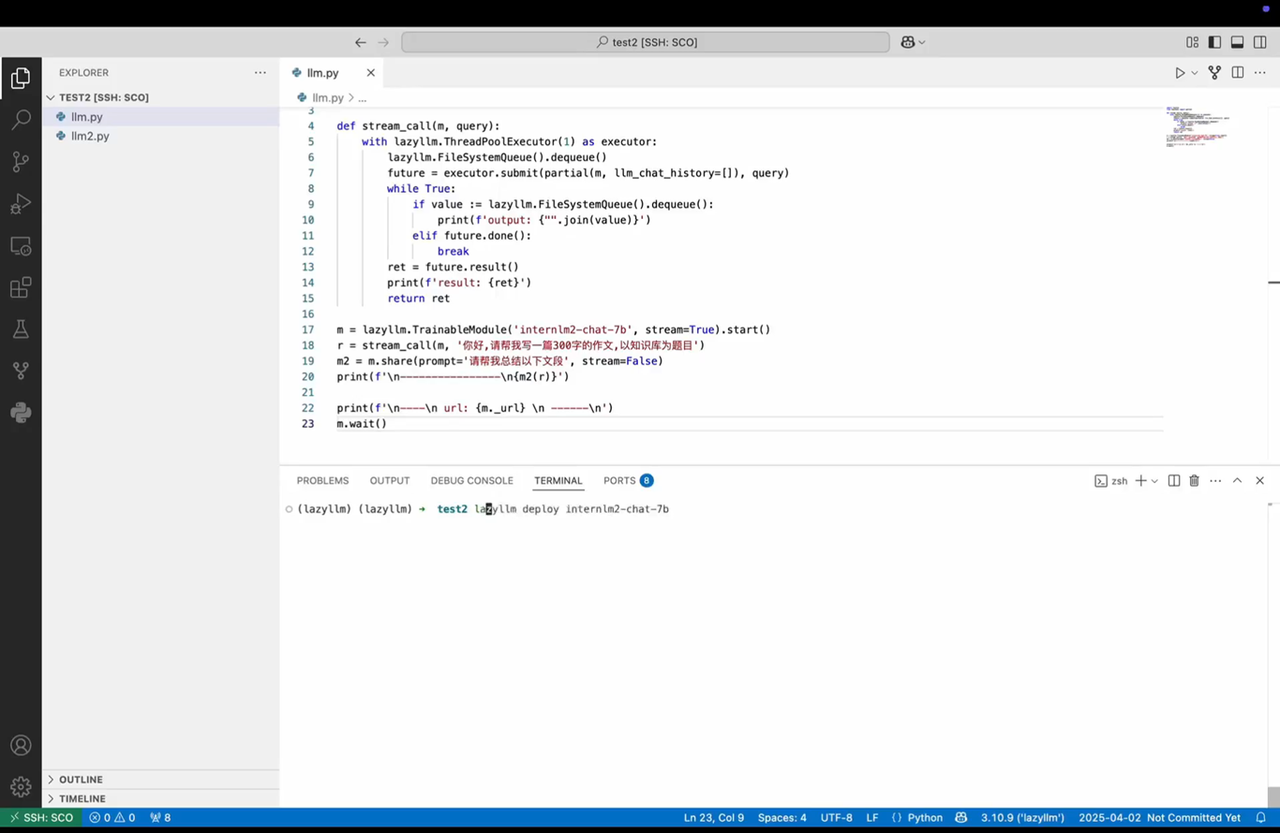

 ### 5. 三行聊天机器人 🤖

用 LazyLLM 构造一个简单的聊天机器人只需三行代码。这里引入 lazyllm.WebModule，它可以将任意数据流封装为一个Web服务，让您可以在图形界面进行对话调试。



In [ ]:
import lazyllm
llm = lazyllm.TrainableModule("internlm2-chat-7b").prompt("你扮演一只小猫，在每次回答问题都要加上喵喵喵")
webpage = lazyllm.WebModule(llm, port=23466, history=[llm], stream=True).start().wait()



上面代码中的`WebModule`：

* 指定用大模型llm来作为对话的机器人;
* `port`指定了聊天界面发布的端口；
* `history`中指定了要将llm的输出作为历史信息，这样机器人就具有了历史对话记忆能力；
* `stream`开启了输出的对话是流式的；
* `start`用于启动整个聊天机器人的部署；
* `wait`表示启动后就一直服务不停止，如果不加上服务部署好后会立刻停止；

[相关视频：video/a3chat2.mp4](video/a3chat2.mp4)

## 数据流简介 🔀

LazyLLM是一款以数据流（Data Flow）为核心的多Agent大模型应用开发框架，所以 LazyLLM 中定义了大量的数据流组件，配合 LazyLLM 中提供的工具和组件，可以让您像搭积木一样搭建复杂的大模型应用。数据流的核心设计思路是无需您手动对数据流动进行指定，而是通过数据流内部将上一阶段的数据直接分发给对应的下游接收组件。LazyLLM支持Pipeline、Parallel、Switch、If、Loop、Diverter、Warp、Graph等数据流。

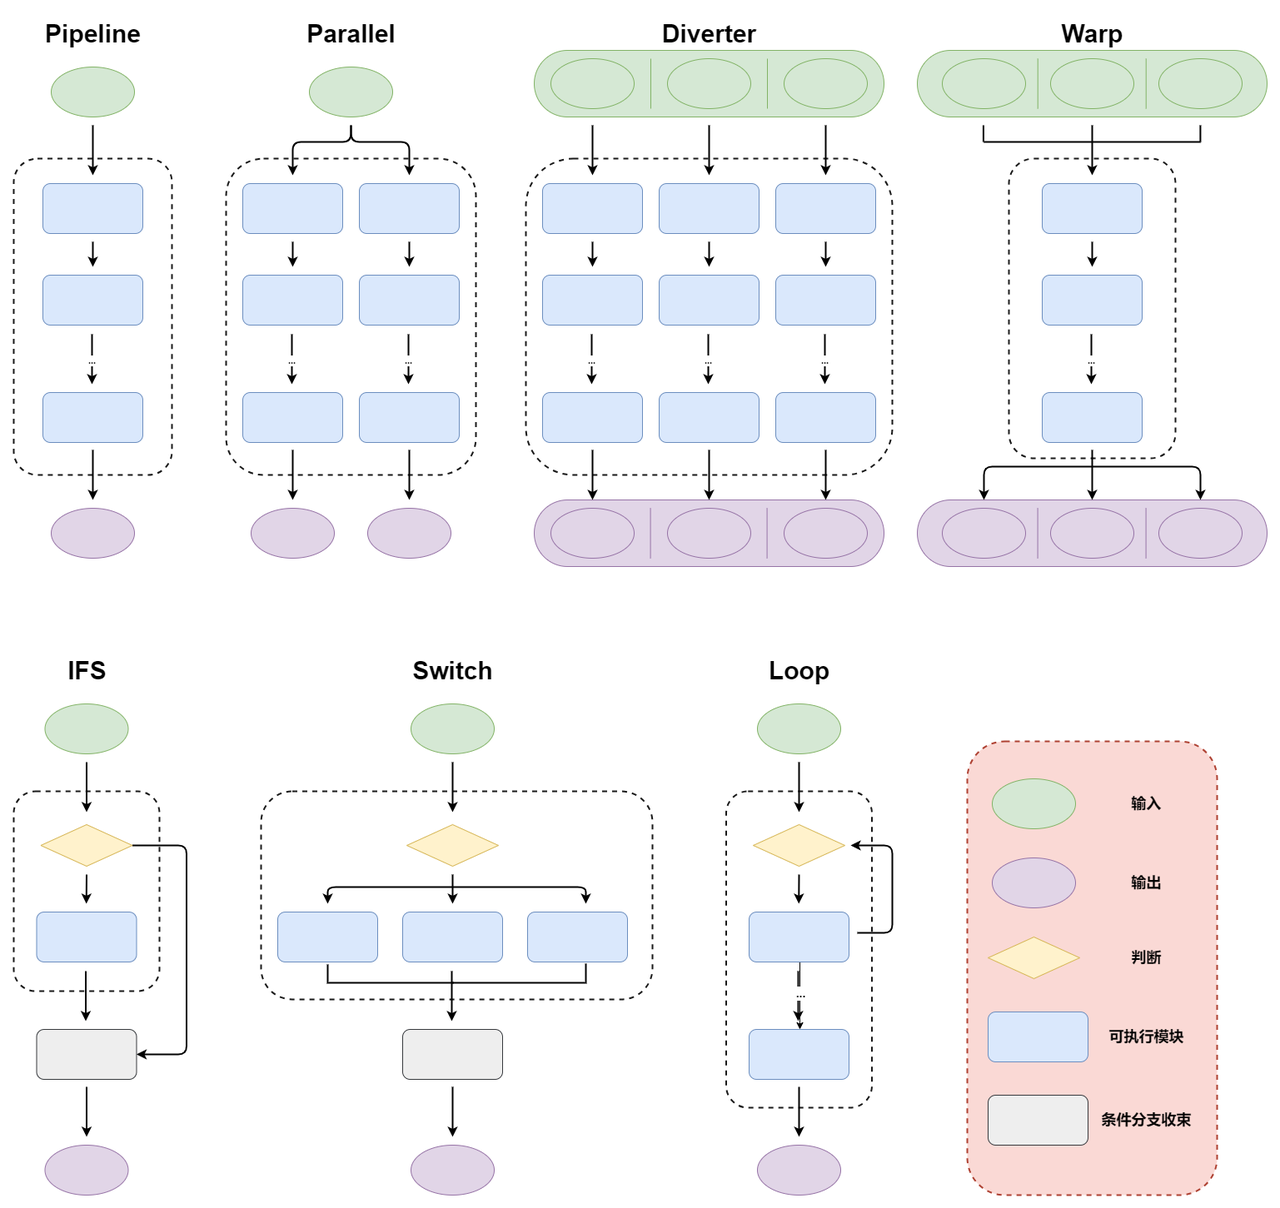
本节将详细为您介绍 LazyLLM 中的各种数据流，方便您在接下来的教程中理解和使用。

>注意：
>
>LazyLLM 支持数据流的 with 语句。with 语句可以让数据流定义代码更加的简洁和清晰。下面关于数据流的所有例子不仅展示了基于函数式的数据流构建，同时在右侧也对应展示了通过 with 语法定义的数据流，with语句的巧妙之处在于定义代码的缩进与目标数据流结构有一定的关联性，可以清晰的看出整体结构。

 ### 6. Pipeline

Pipeline 是顺次执行的数据流，上一个阶段的输出成为下一个阶段的输入。pipeline 支持函数和仿函数（或仿函数的 type），其工作流如下所示：



```bash
input -> module1 -> ... -> moduleN -> out
```


下面是通过 Pipeline 执行顺序结构程序的例子, 任意函数、匿名函数以及可调用实例（含\_\_call\_\_()函数的类）都可以作为 pipeline 中的一员。

函数式：



[代码GitHub链接](https://github.com/LazyAGI/Tutorial/blob/7abc91dbb82a007a78731845dd8c360ac0cc1e75/rag/codes/chapter3/pipeline.py#L1)

In [ ]:
import lazyllm

f1 = lambda x: x * 2

def f2(input):
  return input - 1

class AddOneFunctor(object):
  def __call__(self, x): return x + 1

f3 = AddOneFunctor()

# 手动调用：
inp = 2
x1 = f1(inp)
x2 = f2(x1)
x3 = f3(x2)
out_normal = AddOneFunctor()(x3)

# 使用数据流
ppl = lazyllm.pipeline(f1, f2, f3, AddOneFunctor)
out_ppl1 = ppl(inp)

print(f"输入为{inp},手动调用输出:", out_normal)
print(f"输入为{inp},数据流输出:", out_ppl1)




输出：

```bash
输入为2,手动调用输出: 5
输入为2,数据流输出: 5
```

with式：



[代码GitHub链接](https://github.com/LazyAGI/Tutorial/blob/7abc91dbb82a007a78731845dd8c360ac0cc1e75/rag/codes/chapter3/pipeline_with.py#L1)

In [ ]:
import lazyllm

f1 = lambda x: x * 2

def f2(input):
  return input - 1

class AddOneFunctor(object):
  def __call__(self, x): return x + 1

f3 = AddOneFunctor()

# 使用with方式的数据流
with lazyllm.pipeline() as ppl:
    ppl.func1 = f1
    ppl.func2 = f2
    ppl.func3 = f3
    ppl.func4 = AddOneFunctor

inp = 2
out_ppl1 = ppl(inp)

print(f"输入为{inp},数据流输出:", out_ppl1)



输出：

```bash
输入为2,数据流输出: 5
```

[相关视频：video/1pipeline.mp4](video/1pipeline.mp4)

[相关视频：video/1pipeline_with.mp4](video/1pipeline_with.mp4)

 ### 7. Parallel

Parallel支持我们并行调用多个pipeline，其数据流示意如下：



```bash
      /> module11 -> ... -> module1N -> out1 \
input ->  module21 -> ... -> module2N -> out2 -> (out1, out2, out3)
      \> module31 -> ... -> module3N -> out3 /
```



Parallel支持对输出格式进行格式化处理，方便下游组件进行针对性使用，目前Parallel支持输出字典、元组、列表和字符串形式的输出，具体效果可见下方例子：

函数式：



[代码GitHub链接](https://github.com/LazyAGI/Tutorial/blob/7abc91dbb82a007a78731845dd8c360ac0cc1e75/rag/codes/chapter3/parallel.py#L1)

In [ ]:
import lazyllm

test1 = lambda a: a + 1
test2 = lambda a: a * 4
test3 = lambda a: a / 2

prl1 = lazyllm.parallel(test1, test2, test3)
prl2 = lazyllm.parallel(path1=test1, path2=test2, path3=test3).asdict
prl3 = lazyllm.parallel(test1, test2, test3).astuple
prl4 = lazyllm.parallel(test1, test2, test3).aslist
prl5 = lazyllm.parallel(test1, test2, test3).join('，')

print("默认输出：prl1(1) -> ", prl1(1), type(prl1(1)))
print("输出字典：prl2(1) -> ", prl2(1), type(prl2(1)))
print("输出元组：prl3(1) -> ", prl3(1), type(prl3(1)))
print("输出列表：prl4(1) -> ", prl4(1), type(prl4(1)))
print("输出字符串：prl5(1) -> ", prl5(1), type(prl5(1)))



输出：



```bash
默认输出：prl1(1) ->  (2, 4, 0.5) <class 'lazyllm.common.common.package'>
输出字典：prl2(1) ->  {'path1': 2, 'path2': 4, 'path3': 0.5} <class 'dict'>
输出元组：prl3(1) ->  (2, 4, 0.5) <class 'tuple'>
输出列表：prl4(1) ->  [2, 4, 0.5] <class 'list'>
输出字符串：prl5(1) ->  2，4，0.5 <class 'str'>
```

with式（[代码GitHub链接](https://github.com/LazyAGI/Tutorial/blob/7abc91dbb82a007a78731845dd8c360ac0cc1e75/rag/codes/chapter3/parallel_with.py#L1)）：

In [ ]:
import lazyllm

test1 = lambda a: a + 1
test2 = lambda a: a * 4
test3 = lambda a: a / 2

with lazyllm.parallel() as prl1:
    prl1.func1 = test1
    prl1.func2 = test2
    prl1.func3 = test3

with lazyllm.parallel().asdict as prl2:
    prl2.path1 = test1
    prl2.path2 = test2
    prl2.path3 = test3

with lazyllm.parallel().astuple as prl3:
    prl3.func1 = test1
    prl3.func2 = test2
    prl3.func3 = test3

with lazyllm.parallel().aslist as prl4:
    prl4.func1 = test1
    prl4.func2 = test2
    prl4.func3 = test3

with lazyllm.parallel().join('，') as prl5:
    prl5.func1 = test1
    prl5.func2 = test2
    prl5.func3 = test3

print("默认输出：prl1(1) -> ", prl1(1), type(prl1(1)))
print("输出字典：prl2(1) -> ", prl2(1), type(prl2(1)))
print("输出元组：prl3(1) -> ", prl3(1), type(prl3(1)))
print("输出列表：prl4(1) -> ", prl4(1), type(prl4(1)))
print("输出字符串：prl5(1) -> ", prl5(1), type(prl5(1)))



输出：



```bash
默认输出：prl1(1) ->  (2, 4, 0.5) <class 'lazyllm.common.common.package'>
输出字典：prl2(1) ->  {'path1': 2, 'path2': 4, 'path3': 0.5} <class 'dict'>
输出元组：prl3(1) ->  (2, 4, 0.5) <class 'tuple'>
输出列表：prl4(1) ->  [2, 4, 0.5] <class 'list'>
输出字符串：prl5(1) ->  2，4，0.5 <class 'str'>
```

[相关视频：video/2parallel.mp4](video/2parallel.mp4)

[相关视频：video/2parallel_with.mp4](video/2parallel_with.mp4)


 ### 8. Diverter

Diverter是一种专门的并行处理工具，其中多个输入分别通过一系列并行的模块。然后将输出聚合返回。



```bash
#                 /> in1 -> module11 -> ... -> module1N -> out1 \
# (in1, in2, in3) -> in2 -> module21 -> ... -> module2N -> out2 -> (out1, out2, out3)
#                 \> in3 -> module31 -> ... -> module3N -> out3 /
```



当您拥有可以并行执行的不同数据处理管道，并希望在单个流构造中管理它们时，该工具非常有用。和Parallel一样，该工具支持对输出格式进行格式化处理，目前支持输出字典、元组、列表和字符串形式的输出，具体效果可见下方例子：

函数式（[代码GitHub链接](https://github.com/LazyAGI/Tutorial/blob/7abc91dbb82a007a78731845dd8c360ac0cc1e75/rag/codes/chapter3/diverter.py#L1)）：



In [ ]:
import lazyllm

test1 = lambda a: a + 1
test2 = lambda a: a * 4
test3 = lambda a: a / 2

prl1 = lazyllm.diverter(test1, test2, test3)
prl2 = lazyllm.diverter(path1=test1, path2=test2, path3=test3).asdict
prl3 = lazyllm.diverter(test1, test2, test3).astuple
prl4 = lazyllm.diverter(test1, test2, test3).aslist
prl5 = lazyllm.diverter(test1, test2, test3).join('，')

inputs = [1, 2, 3]

print("默认输出：prl1(1) -> ", prl1(inputs), type(prl1(inputs)))
print("输出字典：prl2(1) -> ", prl2(inputs), type(prl2(inputs)))
print("输出元组：prl3(1) -> ", prl3(inputs), type(prl3(inputs)))
print("输出列表：prl4(1) -> ", prl4(inputs), type(prl4(inputs)))
print("输出字符串：prl5(1) -> ", prl5(inputs), type(prl5(inputs)))



输出：



```bash
默认输出：prl1(1) ->  (2, 8, 1.5) <class 'lazyllm.common.common.package'>
输出字典：prl2(1) ->  {'path1': 2, 'path2': 8, 'path3': 1.5} <class 'dict'>
输出元组：prl3(1) ->  (2, 8, 1.5) <class 'tuple'>
输出列表：prl4(1) ->  [2, 8, 1.5] <class 'list'>
输出字符串：prl5(1) ->  2，8，1.5 <class 'str'>
```

with式（[代码GitHub链接](https://github.com/LazyAGI/Tutorial/blob/7abc91dbb82a007a78731845dd8c360ac0cc1e75/rag/codes/chapter3/diverter_with.py#L1)）：

In [ ]:
import lazyllm

test1 = lambda a: a + 1
test2 = lambda a: a * 4
test3 = lambda a: a / 2

with lazyllm.diverter() as prl1:
    prl1.func1 = test1
    prl1.func2 = test2
    prl1.func3 = test3

with lazyllm.diverter().asdict as prl2:
    prl2.func1 = test1
    prl2.func2 = test2
    prl2.func3 = test3

with lazyllm.diverter().astuple as prl3:
    prl3.func1 = test1
    prl3.func2 = test2
    prl3.func3 = test3

with lazyllm.diverter().aslist as prl4:
    prl4.func1 = test1
    prl4.func2 = test2
    prl4.func3 = test3

with lazyllm.diverter().join('，') as prl5:
    prl5.func1 = test1
    prl5.func2 = test2
    prl5.func3 = test3

inputs = [1, 2, 3]

print("默认输出：prl1(1) -> ", prl1(inputs), type(prl1(inputs)))
print("输出字典：prl2(1) -> ", prl2(inputs), type(prl2(inputs)))
print("输出元组：prl3(1) -> ", prl3(inputs), type(prl3(inputs)))
print("输出列表：prl4(1) -> ", prl4(inputs), type(prl4(inputs)))
print("输出字符串：prl5(1) -> ", prl5(inputs), type(prl5(inputs)))



输出：



```bash
默认输出：prl1(1) ->  (2, 8, 1.5) <class 'lazyllm.common.common.package'>
输出字典：prl2(1) ->  {'func1': 2, 'func2': 8, 'func3': 1.5} <class 'dict'>
输出元组：prl3(1) ->  (2, 8, 1.5) <class 'tuple'>
输出列表：prl4(1) ->  [2, 8, 1.5] <class 'list'>
输出字符串：prl5(1) ->  2，8，1.5 <class 'str'>
```



[相关视频：video/3diverter.mp4](video/3diverter.mp4)

[相关视频：video/3diverter_with.mp4](video/3diverter_with.mp4)


 ### 9. Warp

Warp是一款强大的控制流工具，旨在将同一处理模块并行地应用于一系列输入数据。它通过高效地“形变”单个模块至各个输入，确保每个输入都能得到并行处理，从而大幅提升处理效率。

工作原理示意图：



```bash
#                 /> in1 \                            /> out1 \
# (in1, in2, in3) -> in2 -> module1 -> ... -> moduleN -> out2 -> (out1, out2, out3)
#                 \> in3 /                            \> out3 /
```

>​**注意**​：
>
>* Warp流不应用于异步任务，如训练和部署。
>* Warp流不支持字典输出

与Parallel工具类似，Warp支持对输出格式进行灵活处理。目前，它能够输出元组、列表和字符串形式的结果输出（注意：暂不支持字典输出）。具体的格式化效果及示例，请参见下方例子：

函数式（[代码GitHub链接](https://github.com/LazyAGI/Tutorial/blob/7abc91dbb82a007a78731845dd8c360ac0cc1e75/rag/codes/chapter3/warp.py#L1)）：



In [ ]:
import lazyllm

test1 = lambda a: a + 1
test2 = lambda a: a * 4
test3 = lambda a: a / 2

prl1 = lazyllm.warp(test1, test2, test3)
# prl2 = lazyllm.warp(path1=test1, path2=test2, path3=test3).asdict # Not Implemented
prl3 = lazyllm.warp(test1, test2, test3).astuple
prl4 = lazyllm.warp(test1, test2, test3).aslist
prl5 = lazyllm.warp(test1, test2, test3).join('，')

inputs = [1, 2, 3]

print("默认输出：prl1(1) -> ", prl1(inputs), type(prl1(inputs)))
print("输出元组：prl3(1) -> ", prl3(inputs), type(prl3(inputs)))
print("输出列表：prl4(1) -> ", prl4(inputs), type(prl4(inputs)))
print("输出字符串：prl5(1) -> ", prl5(inputs), type(prl5(inputs)))



输出：



```bash
默认输出：prl1(1) ->  (4.0, 6.0, 8.0) <class 'lazyllm.common.common.package'>
输出元组：prl3(1) ->  (4.0, 6.0, 8.0) <class 'tuple'>
输出列表：prl4(1) ->  [4.0, 6.0, 8.0] <class 'list'>
输出字符串：prl5(1) ->  4.0，6.0，8.0 <class 'str'>
```

with式（[代码GitHub链接](https://github.com/LazyAGI/Tutorial/blob/7abc91dbb82a007a78731845dd8c360ac0cc1e75/rag/codes/chapter3/warp_with.py#L1)）：

In [ ]:
import lazyllm

test1 = lambda a: a + 1
test2 = lambda a: a * 4
test3 = lambda a: a / 2

with lazyllm.warp() as prl1:
    prl1.func1 = test1
    prl1.func2 = test2
    prl1.func3 = test3

with lazyllm.warp().astuple as prl3:
    prl3.func1 = test1
    prl3.func2 = test2
    prl3.func3 = test3

with lazyllm.warp().aslist as prl4:
    prl4.func1 = test1
    prl4.func2 = test2
    prl4.func3 = test3

with lazyllm.warp().join('，') as prl5:
    prl5.func1 = test1
    prl5.func2 = test2
    prl5.func3 = test3

inputs = [1, 2, 3]

print("默认输出：prl1(1) -> ", prl1(inputs), type(prl1(inputs)))
print("输出元组：prl3(1) -> ", prl3(inputs), type(prl3(inputs)))
print("输出列表：prl4(1) -> ", prl4(inputs), type(prl4(inputs)))
print("输出字符串：prl5(1) -> ", prl5(inputs), type(prl5(inputs)))



输出：



```bash
默认输出：prl1(1) ->  (4.0, 6.0, 8.0) <class 'lazyllm.common.common.package'>
输出元组：prl3(1) ->  (4.0, 6.0, 8.0) <class 'tuple'>
输出列表：prl4(1) ->  [4.0, 6.0, 8.0] <class 'list'>
输出字符串：prl5(1) ->  4.0，6.0，8.0 <class 'str'>
```



[相关视频：video/4warp.mp4](video/4warp.mp4)

[相关视频：video/4warp_with.mp4](video/4warp_with.mp4)


 ### 10. IFS

IFS是LazyLLM框架中实现的If-Else功能，可根据条件评估结果选择执行两条路径之一（条件为真的路径或条件判断为假的路径）。IFS使用with语句没有意义，所以这里仅展示函数式的使用：



[代码GitHub链接](https://github.com/LazyAGI/Tutorial/blob/7abc91dbb82a007a78731845dd8c360ac0cc1e75/rag/codes/chapter3/ifs.py#L1)

In [ ]:
import lazyllm

cond = lambda x: x > 0
true_path = lambda x: x * 2
false_path = lambda x: -x

ifs_flow = lazyllm.ifs(cond, true_path, false_path)

res1 = ifs_flow(10)
print('输入：10，输出：', res1)
res2 = ifs_flow(-5)
print('输入：-5，输出：', res2)



输出：



```bash
输入: 10,输出： 20
输入：-5,输出： 5
```



[相关视频：video/5ifs.mp4](video/5ifs.mp4)


 ### 11. Switch

Switch数据流工具提供了一种根据表达式的值或条件的真实性来选择不同流的方法，如下所示。它类似于其他编程语言中的switch-case语句。

用户在使用该控制流工具的过程中需要定义好条件控制函数cond，及其对应的分支函数moduleX（可以是其他的控制流，如：Pipeline等）。其中有个特殊的条件控制函数可以直接设置为字符串`default`来作为兜底的默认分支。

工作原理示意图：



```bash
# switch(exp):
#     case cond1: input -> module11 -> ... -> module1N -> out; break
#     case cond2: input -> module21 -> ... -> module2N -> out; break
#     case cond3: input -> module31 -> ... -> module3N -> out; break
```



另外值得注意的是Switch中有一个叫做`judge_on_full_input`的参数，默认情况下该参数为True，这意味着每次输入到Switch中的数据都会同时作为条件控制函数和分支函数的输入；如果该参数设置为False，这意味着至少需要两个输入，其中第一个会作为条件控制函数的输入，剩下的会作为分支函数的输入。具体示例如下所示：

函数式（[代码GitHub链接](https://github.com/LazyAGI/Tutorial/blob/7abc91dbb82a007a78731845dd8c360ac0cc1e75/rag/codes/chapter3/switch.py#L1)）：



In [ ]:
import lazyllm

# 条件函数
is_positive = lambda x: x > 0
is_negative = lambda x: x < 0

# 每个条件函数对应一个分支函数：
positive_path = lambda x: 2 * x
negative_path = lambda x : -x
default_path = lambda x : '000'

# switch构建1（x同时作为条件函数和分支函数的输入）：
switch1 = lazyllm.switch(
    is_positive, positive_path,
    is_negative, negative_path,
    'default', default_path)

# Show:
print('\n输入x同时作为条件函数和分支函数的输入：')
print("1Path Positive: ", switch1(2)) # 2不仅传入条件函数，2也传入对应的分支函数；
print("1Path Default:  ", switch1(0))
print("1Path Negative: ", switch1(-5))

# switch构建2（条件函数和分支函数的输入指定不同的值）：
switch2 = lazyllm.switch(
    is_positive, positive_path,
    is_negative, negative_path,
    'default', default_path,
    judge_on_full_input=False)

# Show:
print('\n输入x,y按位置分别作为条件函数和分支函数的输入：')
print("2Path Positive: ", switch2(-1,2)) # -1传入条件函数，2传入对应分支函数；
print("2Path Default:  ", switch2(1,2))
print("2Path Negative: ", switch2(0, 2))



输出：



```bash
输入x同时作为条件函数和分支函数的输入：
1Path Positive:  4
1Path Default:   000
1Path Negative:  5

输入x,y按位置分别作为条件函数和分支函数的输入：
2Path Positive:  -2
2Path Default:   4
2Path Negative:  000
```

with式（[代码GitHub链接](https://github.com/LazyAGI/Tutorial/blob/7abc91dbb82a007a78731845dd8c360ac0cc1e75/rag/codes/chapter3/switch_with.py#L1)）：



In [ ]:
import lazyllm

# 条件函数
is_positive = lambda x: x > 0
is_negative = lambda x: x < 0

# 每个条件函数对应一个分支函数：
positive_path = lambda x: 2 * x
negative_path = lambda x : -x
default_path = lambda x : '000'

# switch构建1（x同时作为条件函数和分支函数的输入）：
with lazyllm.switch() as sw1:
    sw1.case(is_positive, positive_path)
    sw1.case(is_negative, negative_path)
    sw1.case('default', default_path)

# Show:
print('\n输入x同时作为条件函数和分支函数的输入：')
print("1Path Positive: ", sw1(2)) # 2不仅传入条件函数，2也传入对应的分支函数；
print("1Path Default:  ", sw1(0))
print("1Path Negative: ", sw1(-5))

# switch构建2（条件函数和分支函数的输入指定不同的值）：
with lazyllm.switch(judge_on_full_input=False) as sw2:  # 分离条件函数和分支函数的关键开关。注意默认是True
    sw2.case(is_positive, positive_path)
    sw2.case(is_negative, negative_path)
    sw2.case('default', default_path)

# Show:
print('\n输入x,y按位置分别作为条件函数和分支函数的输入：')
print("2Path Positive: ", sw2(-1,2)) # -1传入条件函数，2传入对应分支函数；
print("2Path Default:  ", sw2(1,2))
print("2Path Negative: ", sw2(0, 2))



输出：



```bash
输入x同时作为条件函数和分支函数的输入：
1Path Positive:  4
1Path Default:   000
1Path Negative:  5

输入x,y按位置分别作为条件函数和分支函数的输入：
2Path Positive:  -2
2Path Default:   4
2Path Negative:  000
```



[相关视频：video/6switch.mp4](video/6switch.mp4)

[相关视频：video/6swich_with.mp4](video/6swich_with.mp4)


 ### 12. Loop

Loop是一个循环控制流工具，可以将一系列函数重复应用于输入，直到满足停止条件或达到指定的迭代次数。Loop结构允许定义一个简单的控制流，其中一系列步骤在循环中应用，可以使用可选的停止条件来根据步骤的输出退出循环。

Loop中有个叫`judge_on_full_input`的参数，默认情况该值为True，这意味着，输出的完整结果会被作为条件控制函数和分支函数的输入；如果该值为False，那么输出的结果会被切分为两部分，第一部分会作为条件控制函数的输入，剩下部分作为下次循环的输出。所以当主动设置该参数为False时候要注意，分支函数需要返回至少两个值，第一个值作为条件输入，第二个值作为下次循环的输入。如下面例子中所示：

函数式（[代码GitHub链接](https://github.com/LazyAGI/Tutorial/blob/7abc91dbb82a007a78731845dd8c360ac0cc1e75/rag/codes/chapter3/loop.py#L1)）：



In [ ]:
import lazyllm

# 条件函数
stop_func = lambda x: x > 10

# 分支函数
module_func = lambda x: x * 2

# loop构建1
loop1 = lazyllm.loop(
    module_func,
    stop_condition=stop_func)

# Show:
print('1输出：', loop1(1))

#==========================
# 分支函数2
def module_func2(x):
    print("\tloop: ", x)
    return lazyllm.package(x+1, x*2)

# loop构建2
loop2 = lazyllm.loop(
    module_func2,
    stop_condition=stop_func,
    judge_on_full_input=False)

# Show:
print('2输出：', loop2(1))



输出：



```bash
1输出： 16
        loop:  1
        loop:  2
        loop:  4
        loop:  8
        loop:  16
2输出： (32,)
```

with式（[代码GitHub链接](https://github.com/LazyAGI/Tutorial/blob/7abc91dbb82a007a78731845dd8c360ac0cc1e75/rag/codes/chapter3/loop_with.py#L1)）：

In [ ]:
import lazyllm

# 条件函数
stop_func = lambda x: x > 10

# 分支函数
module_func = lambda x: x
modele_func2 = lambda x: x * 2

# loop构建
with lazyllm.loop(stop_condition=stop_func) as loop1:
    loop1.func1 = module_func
    loop1.func2 = modele_func2

# Show:
print('输出：', loop1(1))

#==========================
# 分支函数2
def module_funcn2(x):
    print("\tloop: ", x)
    return lazyllm.package(x+1, x*2)

# loop构建2
with lazyllm.loop(stop_condition=stop_func, judge_on_full_input=False) as loop2:
    loop2.func1 = module_func
    loop2.func2 = module_funcn2

# Show:
print('2输出：', loop2(1))



输出：



```bash
输出： 16
        loop:  1
        loop:  2
        loop:  4
        loop:  8
        loop:  16
2输出： (32,)
```



[相关视频：video/7loop.mp4](video/7loop.mp4)

[相关视频：video/7loop_with.mp4](video/7loop_with.mp4)


 ### 13. Bind

通过上述对数据流的介绍，我们会发现有一个问题是数据按照预定义的路径流动，我们似乎只能控制入端数据，当我们遇到想要在某个环节引入上两级的数据时就会遇到问题，如下面图示中的in到f3我们很难用上述的流来搭建。

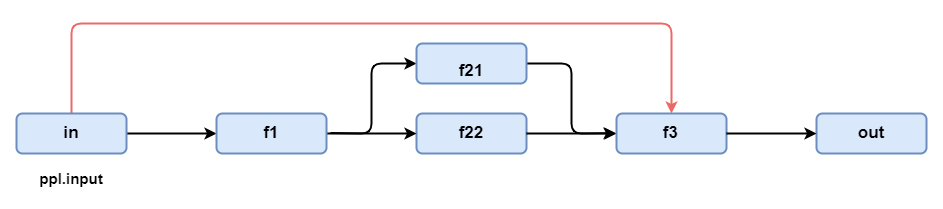

针对这个问题，LazyLLM 提供了一种参数绑定的方式，使数据在数据流中向下游自由地游走（跳跃的数据流）。

让我们先定义f1,f21,f22,f3上图中的几个函数：



In [ ]:
def f1(input): return input ** 2
def f21(input1, input2=0): return input1 + input2 + 1
def f22(input1, input2=0): return input1 + input2 - 1
def f3(in1='placeholder1', in2='placeholder2', in3='placeholder3'): 
    return f'get [input:{in1}], [f21:{in2}], [f23: {in3}]]'


LazyLLM 提供了 lazyllm.bind 函数进行函数绑定，bind 函数接收的参数格式如下所示：



```text
lazyllm.bind(func, param1, param2, ...)
```



其中：

* `func` 为需要进行参数绑定的函数，
* `param1`, `param2` 依次为 `func` 接收的参数。实际上我们观察上图可以发现：
  * 我们需要输入的`param1`就是ppl的输入（ppl.input），此处我们可以通过 ppl.input 在当前数据流获取对应的输入。
  * `param2` 和 `param3` 是f3的上一级，LazyLLM对这种情况定义了一种占位符，\_0。\_0表示数据流中当前节点的上一级输出，如果上一级中有多个输出，则可以通过\_1, \_2, \_3依次获取，这里有两个输出所以分别是\_0, \_1。

基于LazyLLM的参数绑定可以实现上图中的数据跳连：



[代码GitHub链接](https://github.com/LazyAGI/Tutorial/blob/7abc91dbb82a007a78731845dd8c360ac0cc1e75/rag/codes/chapter3/bind.py#L1)

In [ ]:
from lazyllm import pipeline, parallel, bind, _0, _1

with pipeline() as ppl1:
  ppl1.f1 = f1
  with parallel() as ppl1.subprl2:
    ppl1.subprl2.path1 = f21
    ppl1.subprl2.path2 = f22
  ppl1.f3 = bind(f3, ppl1.input, _0, _1)
  
print("ppl1 out: ", ppl1(2))



输出：



```bash
ppl1 out:  get [input:2], [f21:5], [f23: 3]]
```



>注意，参数绑定仅在当前数据流内生效，您无法将外部变量数据绑定至数据流内，也无法跨数据流进行数据绑定。

[相关视频：video/8jump1.mp4](video/8jump1.mp4)


LazyLLM为 bind 函数重载了 | 运算符，可以通过它实现更直观的参数绑定，将函数和参数区分开来（|运算符之前的是被绑定的函数，之后是需要绑定的参数）。此外，子数据流也支持绑定入参。下面我们将上图修改为更复杂的流，我们将数据流输入绑定为subprl2的第一个输入(下图红色箭头线)，上游f1的输出为subprl的第二个输入。

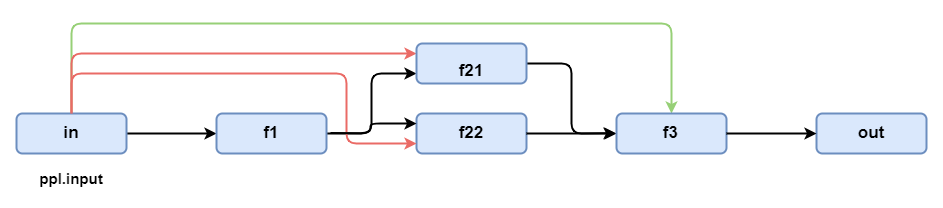



[代码GitHub链接](https://github.com/LazyAGI/Tutorial/blob/7abc91dbb82a007a78731845dd8c360ac0cc1e75/rag/codes/chapter3/bind_more.py#L1)

In [ ]:
from lazyllm import pipeline, parallel, bind, _0, _1

with pipeline() as ppl1:
  ppl1.f1 = f1
  with parallel().bind(ppl1.input, _0) as ppl1.subprl2:
    ppl1.subprl2.path1 = f21
    ppl1.subprl2.path2 = f22
  ppl1.f3 = f3 | bind(ppl1.input, _0, _1)
  
print("ppl1 out: ", ppl1(2))



输出：



```bash
ppl1 out:  get [input:2], [f21:7], [f23: 5]]
```



[相关视频：video/8jump2.mp4](video/8jump2.mp4)


## 基于 LazyLLM 实现RAG

在基础1中我们介绍了rag的具体原理及实现过程，简单RAG的推理步骤只有三步，即检索、增强、生成。这里我们可以通过上面讲述的数据流来重新实现一下这个RAG，使得到一个更清晰的代码块。详细代码如下：



In [ ]:
import lazyllm
from lazyllm import bind

# 文档加载
documents = lazyllm.Document(dataset_path="/mnt/lustre/share_data/dist/cmrc2018/data_kb")
prompt = 'You will act as an AI question-answering assistant and complete a dialogue task. \
          In this task, you need to provide your answers based on the given context and questions.'

with lazyllm.pipeline() as ppl:
    # 检索组件定义
    ppl.retriever = lazyllm.Retriever(doc=documents, group_name="CoarseChunk", similarity="bm25_chinese", topk=3)
    ppl.formatter = (lambda nodes, query: {"query": query, "context_str": "".join([node.get_content() for node in nodes])}) | bind(query=ppl.input)
    # 生成组件定义
    ppl.llm = lazyllm.OnlineChatModule().prompt(lazyllm.ChatPrompter(instruction=prompt, extra_keys=['context_str']))

lazyllm.WebModule(ppl, port=23466).start().wait()



让我们一步步修改上期RAG并实现基于数据流的RAG:

[相关视频：video/rag_pipeline.mp4](video/rag_pipeline.mp4)




